# Brain Tumor Detector

## Get and Load Dataset

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!pip install --upgrade --no-cache-dir gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.7.3
    Uninstalling gdown-4.7.3:
      Successfully uninstalled gdown-4.7.3


In [3]:
!gdown --id 1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj
From (redirected): https://drive.google.com/uc?id=1bXBSfKDaItFigHa5QfcnyTXADG2wlWJj&confirm=t&uuid=be0c580d-91d5-4c68-85f9-1e0ef4ccb18d
To: /content/brain_tumor.zip
100% 156M/156M [00:01<00:00, 80.6MB/s]


In [4]:
!unzip -q brain_tumor.zip

In [5]:
ls -l

total 152152
-rw-r--r-- 1 root root 155791278 Apr  4 19:25 brain_tumor.zip
drwxr-xr-x 1 root root      4096 Apr  3 13:25 sample_data/
drwxr-xr-x 6 root root      4096 Apr  4 19:26 Testing/
drwxr-xr-x 6 root root      4096 Apr  4 19:26 Training/


In [6]:
!sudo apt-get install tree #just to see folder structures, run only on linux systems like colab

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (160 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 121753 files and directories currently install

In [7]:
!tree --dirsfirst --filelimit 4 ./Training/ #just to see folder structures, run only on linux systems like colab

./Training/
├── glioma  [1321 entries exceeds filelimit, not opening dir]
├── meningioma  [1339 entries exceeds filelimit, not opening dir]
├── notumor  [1595 entries exceeds filelimit, not opening dir]
└── pituitary  [1457 entries exceeds filelimit, not opening dir]

4 directories, 0 files


In [8]:
!tree --dirsfirst --filelimit 4 ./Testing/ #just to see folder structures, run only on linux systems like colab

./Testing/
├── glioma  [300 entries exceeds filelimit, not opening dir]
├── meningioma  [306 entries exceeds filelimit, not opening dir]
├── notumor  [405 entries exceeds filelimit, not opening dir]
└── pituitary  [300 entries exceeds filelimit, not opening dir]

4 directories, 0 files


## Load Dependencies

In [9]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix,\
                            classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob

print('TF Version:', tf.__version__)

TF Version: 2.15.0


In [106]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

## Utility functions to create dataset generators

In [18]:
IMG_DIMS = (128, 128)
BATCH_SIZE = 32
IMG_SHAPE = IMG_DIMS + (3,)
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# call this function before running any model to get data into train and validation splits
# data is loaded as a TF dataset in a memory efficient format
def prepare_train_and_val_datasets():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="training",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Training",
        validation_split=0.2,
        subset="validation",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=BATCH_SIZE,
    )

    train_ds = train_ds.prefetch(buffer_size=25)
    val_ds = val_ds.prefetch(buffer_size=25)

    return train_ds, val_ds

# call this function on any trained model to get prediction labels on the test data
# this loads the test dataset from the test directory as a test dataset
# iterates through the above dataset and returns the true labels as well as the predicted labels
def eval_model_on_test(model):
    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        "./Testing",
        class_names=['glioma', 'meningioma', 'notumor', 'pituitary'],
        seed=42,
        image_size=IMG_DIMS,
        batch_size=128,
    )

    test_labels = []
    predictions = []

    for imgs, labels in tqdm(test_ds.take(100),
                             desc='Predicting on Test Data'):
        batch_preds = model.predict(imgs)
        predictions.extend(batch_preds)
        test_labels.extend(labels)

    predictions = np.array(predictions)
    test_labels = np.array(test_labels)

    return test_labels, predictions


### Example usage of the above functions

```
train_ds, val_ds = prepare_train_and_val_datasets()

model = <BIG CNN MODEL>

history = model.fit(
    train_ds, epochs=10,
    validation_data=val_ds,
)

y_true, y_pred = eval_model_on_test(model)


In [19]:
train_ds, val_ds = prepare_train_and_val_datasets()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


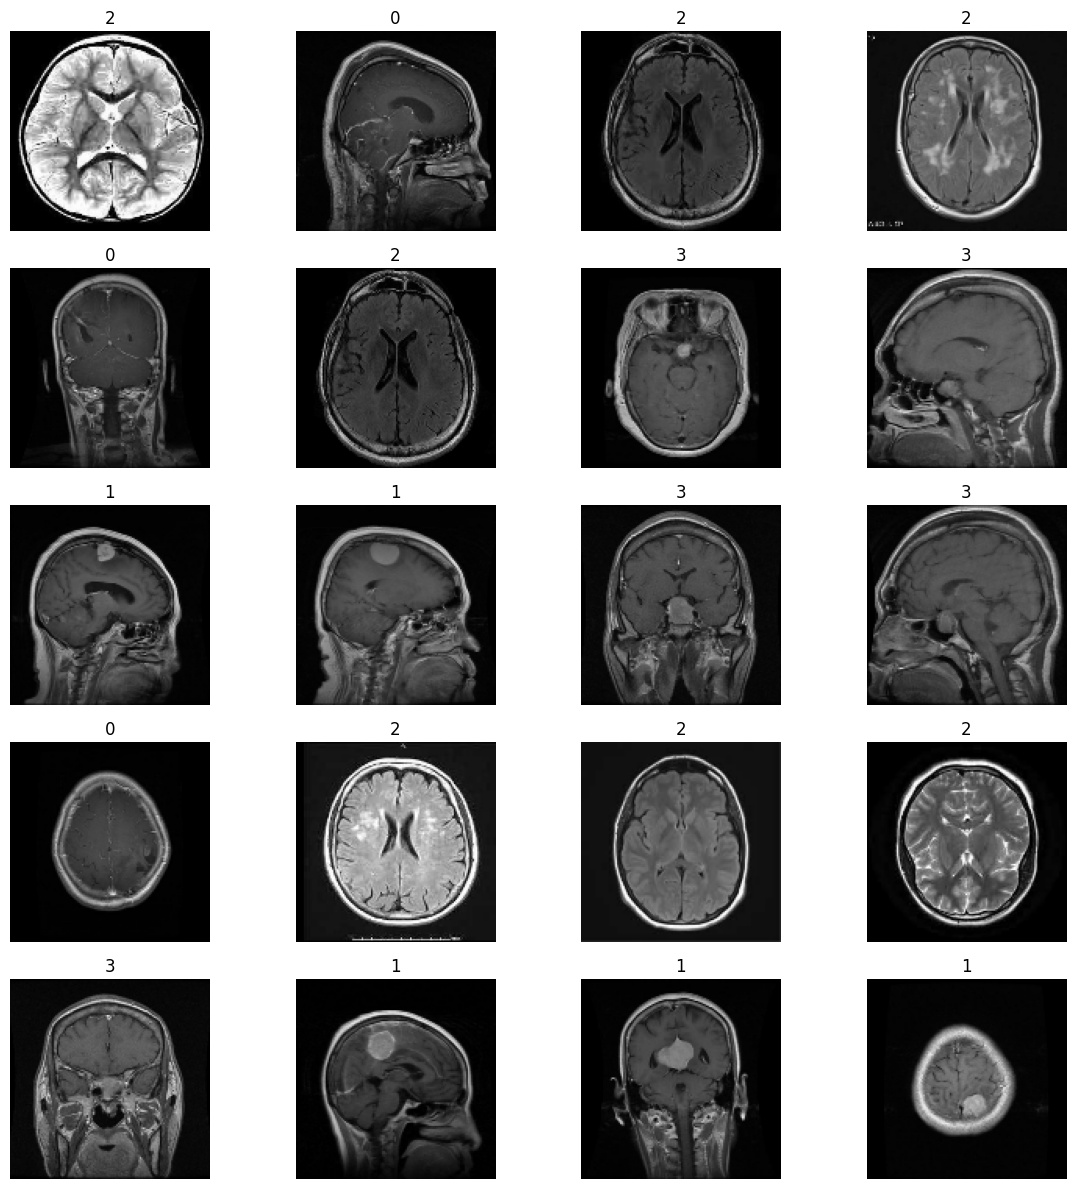

In [20]:
plt.figure(figsize=(12, 12))

for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

In [33]:
mkdir models

mkdir: cannot create directory ‘models’: File exists


In [34]:
recall_dict = {}
f1_weighted_dict = {}



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 flatten_5 (Flatten)         (None, 127008)            0         
                                                                 
 dense_10 (Dense)            (None, 128)               16257152  
                                                                 
 dense_11 (Dense)            (None, 4)                 516       
                                                      

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:10,  1.08s/it]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.85it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.74it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.54it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.45it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.29it/s]

4/4 [==============================] - 0s 4ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.65it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  5.77it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  5.56it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  5.76it/s]

1/1 [==============================] - 0s 87ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.17it/s]


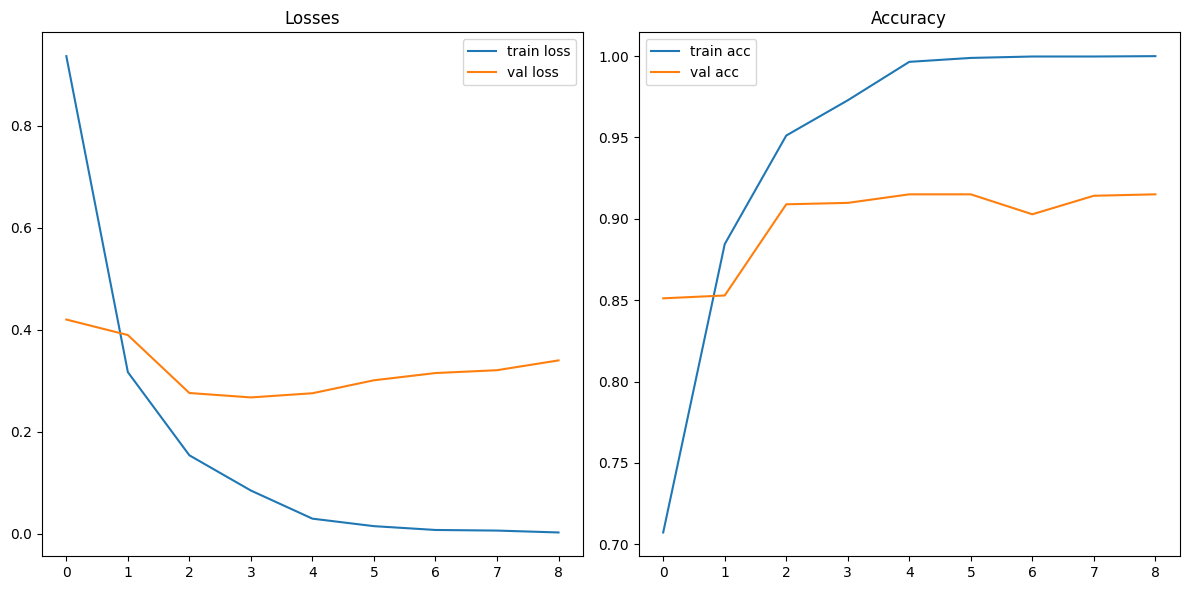

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])


model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions = eval_model_on_test(model)

# get the predicted labels

predicted_labels = np.argmax(predictions, axis=1)

In [36]:
report = classification_report(test_labels, predicted_labels, target_names=classes, output_dict=True)

# Extract meningioma recall
meningioma_recall = report['meningioma']['recall']

# Extract weighted average F1-score
weighted_f1 = report['weighted avg']['f1-score']

recall_dict['CNN_1Layer_Conv2D'] = meningioma_recall
f1_weighted_dict['CNN_1Layer_Conv2D'] = weighted_f1

In [46]:
recall_dict

{'CNN_1Layer_Conv2D': 0.8464052287581699}

In [47]:
train_ds, val_ds = prepare_train_and_val_datasets()

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])


model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                  

Epoch 1/20
143/143 [==============================] - 10s 51ms/step - loss: 0.6300 - accuracy: 0.7490 - val_loss: 0.4119 - val_accuracy: 0.8441
Epoch 2/20
143/143 [==============================] - 6s 39ms/step - loss: 0.2815 - accuracy: 0.8952 - val_loss: 0.2919 - val_accuracy: 0.8993
Epoch 3/20
143/143 [==============================] - 7s 48ms/step - loss: 0.1431 - accuracy: 0.9486 - val_loss: 0.2505 - val_accuracy: 0.9229
Epoch 4/20
143/143 [==============================] - 6s 39ms/step - loss: 0.0691 - accuracy: 0.9770 - val_loss: 0.2840 - val_accuracy: 0.9221
Epoch 5/20
143/143 [==============================] - 6s 39ms/step - loss: 0.0441 - accuracy: 0.9856 - val_loss: 0.2828 - val_accuracy: 0.9273
Epoch 6/20
143/143 [==============================] - 7s 46ms/step - loss: 0.0290 - accuracy: 0.9910 - val_loss: 0.3136 - val_accuracy: 0.9291
Epoch 7/20
143/143 [==============================] - 6s 39ms/step - loss: 0.0252 - accuracy: 0.9917 - val_loss: 0.3213 - val_accuracy: 0.938

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:11,  1.10s/it]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.91it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.81it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.82it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.77it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.56it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.86it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  6.18it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.79it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  7.23it/s]

1/1 [==============================] - 0s 69ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]

              precision    recall  f1-score   support

      glioma       0.93      0.84      0.88       300
  meningioma       0.84      0.84      0.84       306
     notumor       0.95      0.99      0.97       405
   pituitary       0.96      0.99      0.97       300

    accuracy                           0.92      1311
   macro avg       0.92      0.91      0.92      1311
weighted avg       0.92      0.92      0.92      1311



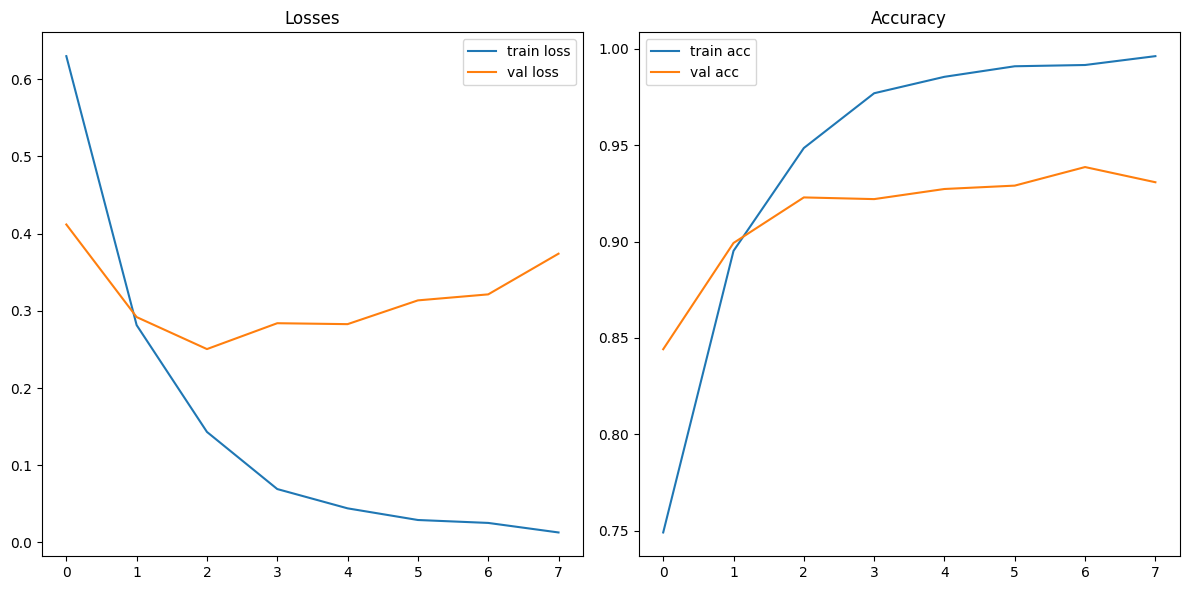

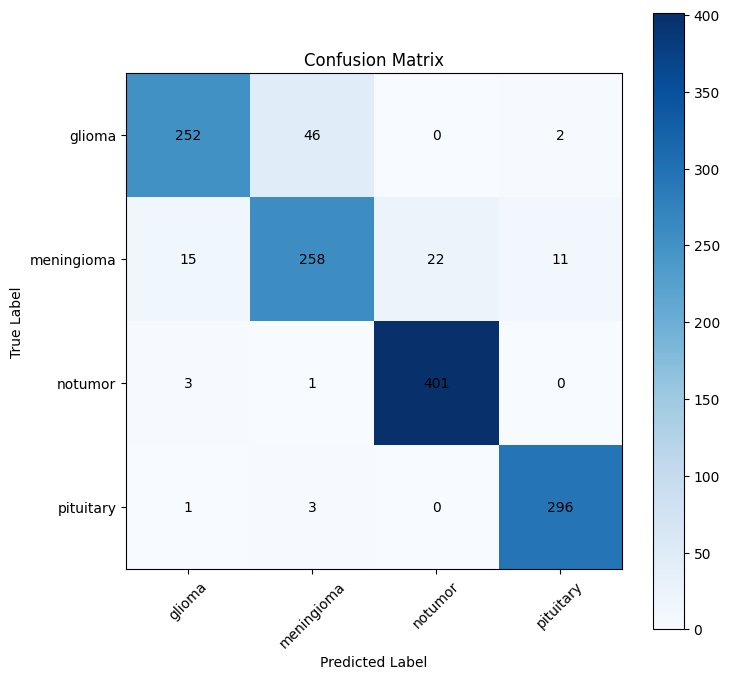

In [48]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history1.history['loss'], label='train loss')
plt.plot(history1.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history1.history['accuracy'], label='train acc')
plt.plot(history1.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions1 = eval_model_on_test(model)

# get the predicted labels

predicted_labels1 = np.argmax(predictions1, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels1, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels1)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('models/brain_tumor_classifier_v1.keras')



In [49]:
report1 = classification_report(test_labels, predicted_labels1, target_names=classes, output_dict=True)

# Extract meningioma recall
meningioma_recall = report1['meningioma']['recall']

# Extract weighted average F1-score
weighted_f1 = report1['weighted avg']['f1-score']

recall_dict['CNN_2Layer_Conv2D'] = meningioma_recall
f1_weighted_dict['CNN_2Layer_Conv2D'] = weighted_f1

recall_dict

{'CNN_1Layer_Conv2D': 0.8464052287581699,
 'CNN_2Layer_Conv2D': 0.8431372549019608}

In [50]:
f1_weighted_dict

{'CNN_1Layer_Conv2D': 0.929325406610462,
 'CNN_2Layer_Conv2D': 0.919806584690261}

In [51]:
train_ds, val_ds = prepare_train_and_val_datasets()

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.summary()

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 61, 61, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 30, 30, 32)        0         
 ng2D)                                  

Epoch 1/20
143/143 [==============================] - 7s 35ms/step - loss: 0.7347 - accuracy: 0.7072 - val_loss: 0.5510 - val_accuracy: 0.7828
Epoch 2/20
143/143 [==============================] - 6s 39ms/step - loss: 0.3883 - accuracy: 0.8547 - val_loss: 0.4205 - val_accuracy: 0.8380
Epoch 3/20
143/143 [==============================] - 7s 49ms/step - loss: 0.2838 - accuracy: 0.9022 - val_loss: 0.3016 - val_accuracy: 0.9019
Epoch 4/20
143/143 [==============================] - 6s 39ms/step - loss: 0.2036 - accuracy: 0.9241 - val_loss: 0.2543 - val_accuracy: 0.9151
Epoch 5/20
143/143 [==============================] - 7s 45ms/step - loss: 0.1317 - accuracy: 0.9523 - val_loss: 0.2285 - val_accuracy: 0.9352
Epoch 6/20
143/143 [==============================] - 7s 46ms/step - loss: 0.1099 - accuracy: 0.9635 - val_loss: 0.2368 - val_accuracy: 0.9282
Epoch 7/20
143/143 [==============================] - 6s 44ms/step - loss: 0.0623 - accuracy: 0.9790 - val_loss: 0.2184 - val_accuracy: 0.9431

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:12,  1.24s/it]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:05,  1.67it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:03,  2.55it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:02,  3.36it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.30it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.12it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:02<00:00,  5.47it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  5.84it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.12it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.48it/s]

1/1 [==============================] - 0s 139ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.06it/s]


              precision    recall  f1-score   support

      glioma       0.93      0.92      0.92       300
  meningioma       0.90      0.89      0.90       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



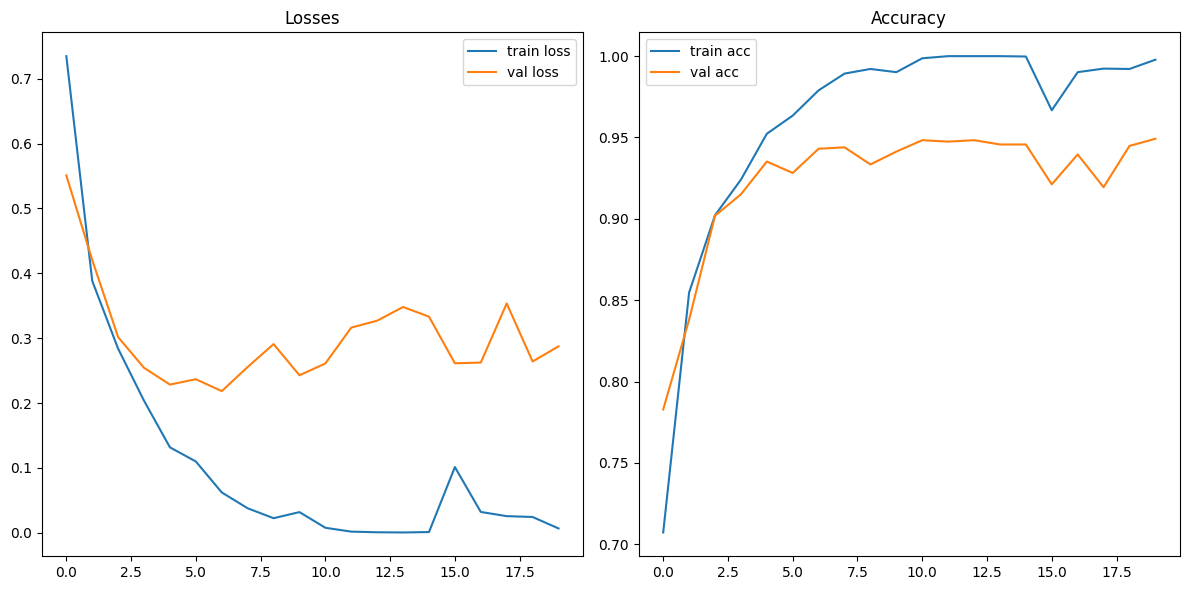

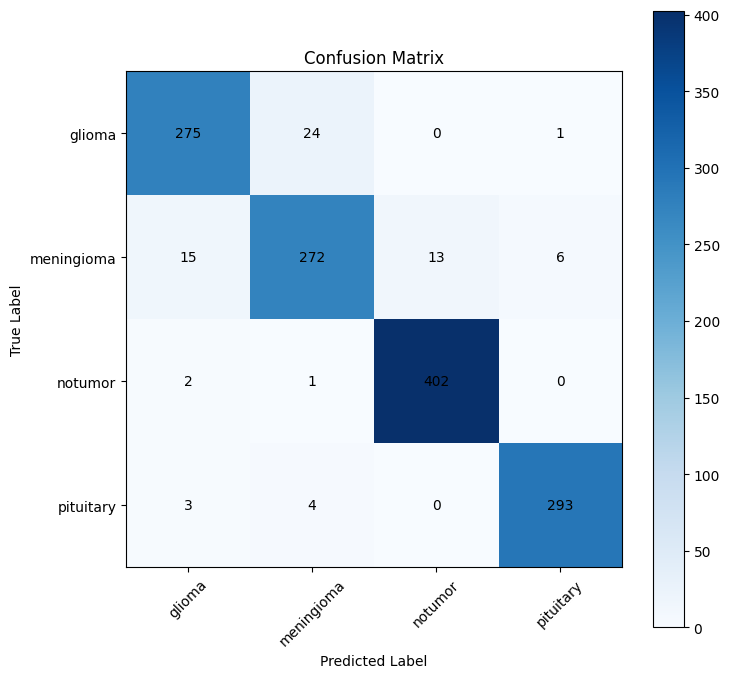

In [52]:
# tarin the model

history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='train loss')
plt.plot(history2.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='train acc')
plt.plot(history2.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions2 = eval_model_on_test(model)

# get the predicted labels

predicted_labels2 = np.argmax(predictions2, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels2, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels2)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('models/brain_tumor_classifier_v2.keras')



In [53]:
report2 = classification_report(test_labels, predicted_labels2, target_names=classes, output_dict=True)

recall_dict['CNN_3Layer_Conv2D'] = report2['meningioma']['recall']
f1_weighted_dict['CNN_3Layer_Conv2D'] = report2['weighted avg']['f1-score']

In [55]:
f1_weighted_dict

{'CNN_1Layer_Conv2D': 0.929325406610462,
 'CNN_2Layer_Conv2D': 0.919806584690261,
 'CNN_3Layer_Conv2D': 0.9471006960550908}

In [57]:
train_ds, val_ds = prepare_train_and_val_datasets()

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)



Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


Epoch 1/20
143/143 [==============================] - 8s 41ms/step - loss: 0.8089 - accuracy: 0.6628 - val_loss: 0.5803 - val_accuracy: 0.8021
Epoch 2/20
143/143 [==============================] - 6s 38ms/step - loss: 0.4570 - accuracy: 0.8280 - val_loss: 0.6108 - val_accuracy: 0.7706
Epoch 3/20
143/143 [==============================] - 6s 44ms/step - loss: 0.3658 - accuracy: 0.8661 - val_loss: 0.3183 - val_accuracy: 0.8923
Epoch 4/20
143/143 [==============================] - 6s 42ms/step - loss: 0.2654 - accuracy: 0.8993 - val_loss: 0.2742 - val_accuracy: 0.9247
Epoch 5/20
143/143 [==============================] - 6s 39ms/step - loss: 0.2029 - accuracy: 0.9300 - val_loss: 0.2958 - val_accuracy: 0.9116
Epoch 6/20
143/143 [==============================] - 6s 41ms/step - loss: 0.1566 - accuracy: 0.9389 - val_loss: 0.2500 - val_accuracy: 0.9247
Epoch 7/20
143/143 [==============================] - 7s 45ms/step - loss: 0.1208 - accuracy: 0.9593 - val_loss: 0.2693 - val_accuracy: 0.9256

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 7ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:11,  1.13s/it]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.87it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.78it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.79it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.44it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:01,  4.93it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.41it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  6.19it/s]

4/4 [==============================] - 0s 6ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.84it/s]

4/4 [==============================] - 0s 5ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.88it/s]

1/1 [==============================] - 0s 132ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.21it/s]

              precision    recall  f1-score   support

      glioma       0.97      0.90      0.93       300
  meningioma       0.89      0.92      0.90       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.95      0.95      0.95      1311



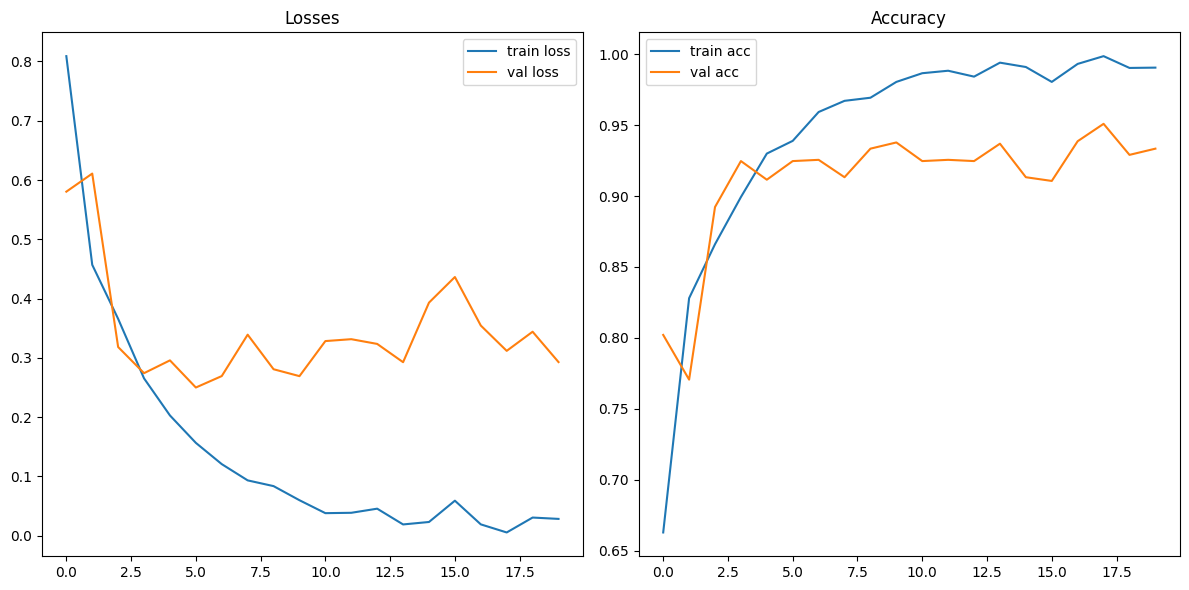

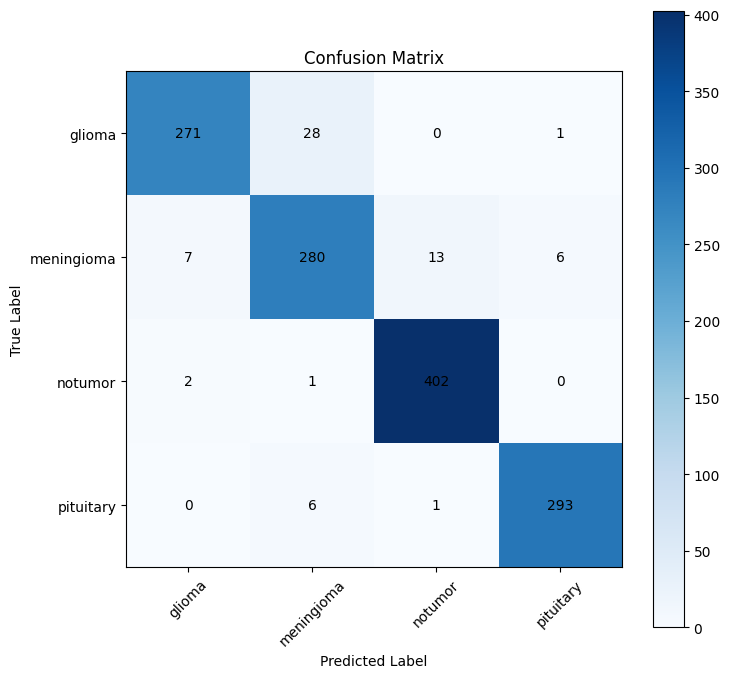

In [58]:
history3 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='train loss')
plt.plot(history3.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history3.history['accuracy'], label='train acc')
plt.plot(history3.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions3 = eval_model_on_test(model)

# get the predicted labels

predicted_labels3 = np.argmax(predictions3, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels3, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels3)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('models/brain_tumor_classifier_v3.keras')



In [59]:
report3 = classification_report(test_labels, predicted_labels3, target_names=classes, output_dict=True)

recall_dict['CNN_4Layer_Conv2D'] = report3['meningioma']['recall']
f1_weighted_dict['CNN_4Layer_Conv2D'] = report3['weighted avg']['f1-score']

In [61]:
f1_weighted_dict

{'CNN_1Layer_Conv2D': 0.929325406610462,
 'CNN_2Layer_Conv2D': 0.919806584690261,
 'CNN_3Layer_Conv2D': 0.9471006960550908,
 'CNN_4Layer_Conv2D': 0.9503438154669683}

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Epoch 1/20
143/143 [==============================] - 10s 46ms/step - loss: 0.7461 - accuracy: 0.6908 - val_loss: 0.4654 - val_accuracy: 0.8336
Epoch 2/20
143/143 [==============================] - 7s 47ms/step - loss: 0.3984 - accuracy: 0.8460 - val_loss: 0.4583 - val_accuracy: 0.8284
Epoch 3/20
143/143 [==============================] - 7s 46ms/step - loss: 0.2877 - accuracy: 0.8965 - val_loss: 0.2554 - val_accuracy: 0.9116
Epoch 4/20
143/143 [==============================] - 6s 40ms/step - loss: 0.1969 - accuracy: 0.9245 - val_loss: 0.2516 - val_accuracy: 0.9221
Epoch 5/20
143/143 [==============================] - 6s 40ms/step - loss: 0.1205 - accuracy: 0.9589 - val_loss: 0.2488 - val_accuracy: 0.9291
Epoch 6/20
143/143 [==============================] - 7s 45ms/step - loss: 0.0949 - accuracy: 0.9661 - val_loss: 0.2217 - val_accuracy: 0.

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:10,  1.06s/it]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.96it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.96it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.93it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.80it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.32it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.90it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:01<00:00,  6.20it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.55it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.71it/s]

1/1 [==============================] - 0s 433ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


              precision    recall  f1-score   support

      glioma       0.96      0.93      0.95       300
  meningioma       0.93      0.91      0.92       306
     notumor       0.97      1.00      0.98       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



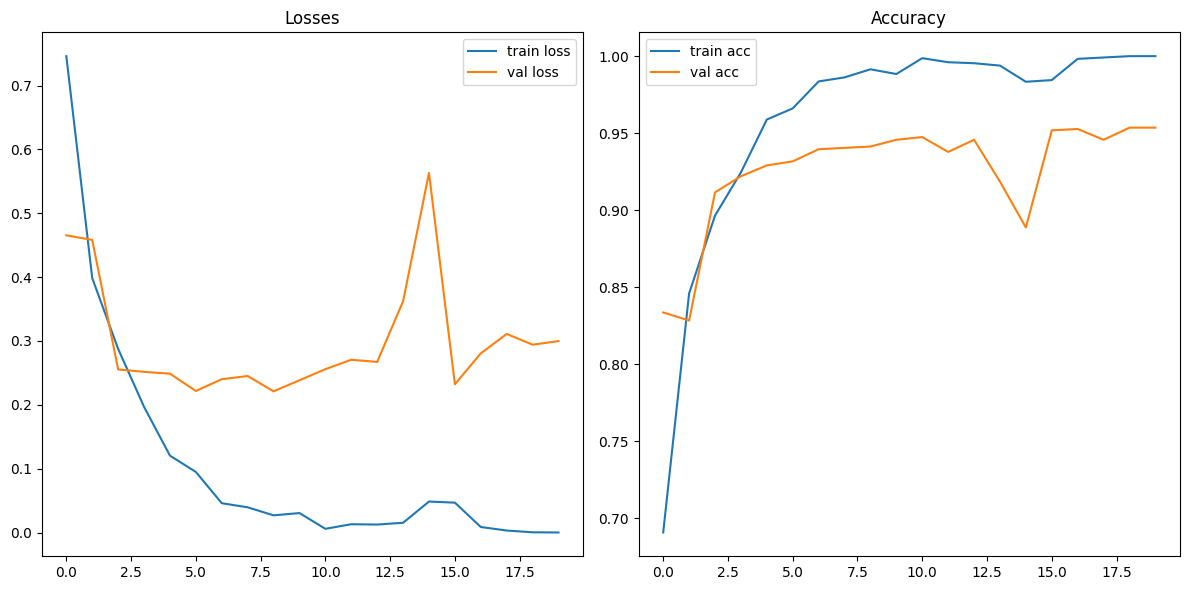

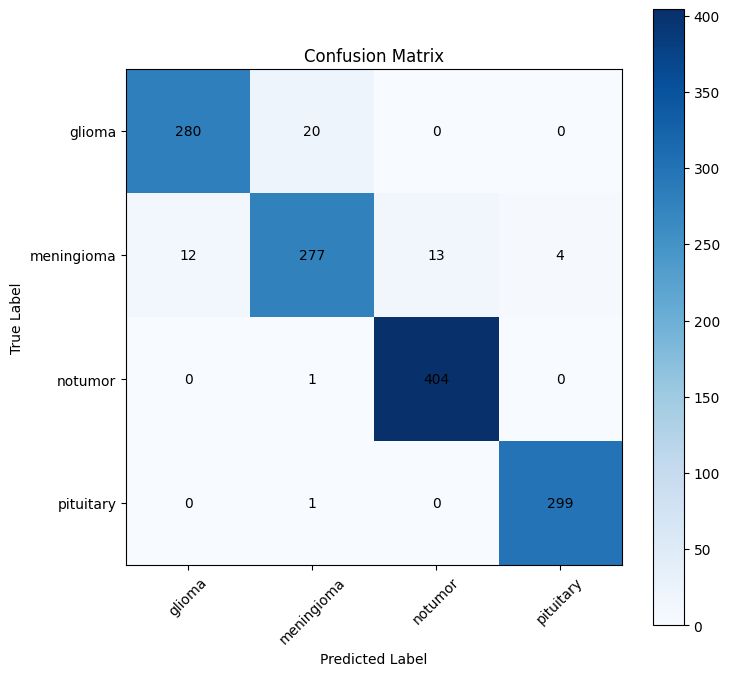

In [62]:
train_ds, val_ds = prepare_train_and_val_datasets()

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history4 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history4.history['loss'], label='train loss')
plt.plot(history4.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history4.history['accuracy'], label='train acc')
plt.plot(history4.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions4 = eval_model_on_test(model)

# get the predicted labels

predicted_labels4 = np.argmax(predictions4, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels4, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels4)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('models/brain_tumor_classifier_v4.keras')

In [63]:
report4 = classification_report(test_labels, predicted_labels4, target_names=classes, output_dict=True)

recall_dict['CNN_3LayerDeeper_Conv2D'] = report4['meningioma']['recall']
f1_weighted_dict['CNN_3LayerDeeper_Conv2D'] = report4['weighted avg']['f1-score']

In [64]:
recall_dict

{'CNN_1Layer_Conv2D': 0.8464052287581699,
 'CNN_2Layer_Conv2D': 0.8431372549019608,
 'CNN_3Layer_Conv2D': 0.8888888888888888,
 'CNN_4Layer_Conv2D': 0.9150326797385621,
 'CNN_3LayerDeeper_Conv2D': 0.9052287581699346}

In [65]:
f1_weighted_dict

{'CNN_1Layer_Conv2D': 0.929325406610462,
 'CNN_2Layer_Conv2D': 0.919806584690261,
 'CNN_3Layer_Conv2D': 0.9471006960550908,
 'CNN_4Layer_Conv2D': 0.9503438154669683,
 'CNN_3LayerDeeper_Conv2D': 0.9607958581643302}

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Epoch 1/20
143/143 [==============================] - 9s 39ms/step - loss: 0.7873 - accuracy: 0.6849 - val_loss: 0.5915 - val_accuracy: 0.7846
Epoch 2/20
143/143 [==============================] - 7s 47ms/step - loss: 0.4271 - accuracy: 0.8400 - val_loss: 0.5283 - val_accuracy: 0.8109
Epoch 3/20
143/143 [==============================] - 6s 40ms/step - loss: 0.3144 - accuracy: 0.8814 - val_loss: 0.3197 - val_accuracy: 0.9063
Epoch 4/20
143/143 [==============================] - 6s 43ms/step - loss: 0.2182 - accuracy: 0.9188 - val_loss: 0.3092 - val_accuracy: 0.8993
Epoch 5/20
143/143 [==============================] - 7s 47ms/step - loss: 0.1621 - accuracy: 0.9422 - val_loss: 0.2956 - val_accuracy: 0.9264
Epoch 6/20
143/143 [==============================] - 6s 41ms/step - loss: 0.1162 - accuracy: 0.9589 - val_loss: 0.2761 - val_accuracy: 0.9

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:10,  1.07s/it]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.91it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.92it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.76it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.62it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.31it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.98it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:01<00:00,  6.58it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  7.01it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  7.02it/s]

1/1 [==============================] - 0s 148ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]

              precision    recall  f1-score   support

      glioma       0.93      0.93      0.93       300
  meningioma       0.92      0.88      0.90       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.96      0.97      0.97       300

    accuracy                           0.95      1311
   macro avg       0.95      0.94      0.94      1311
weighted avg       0.95      0.95      0.95      1311



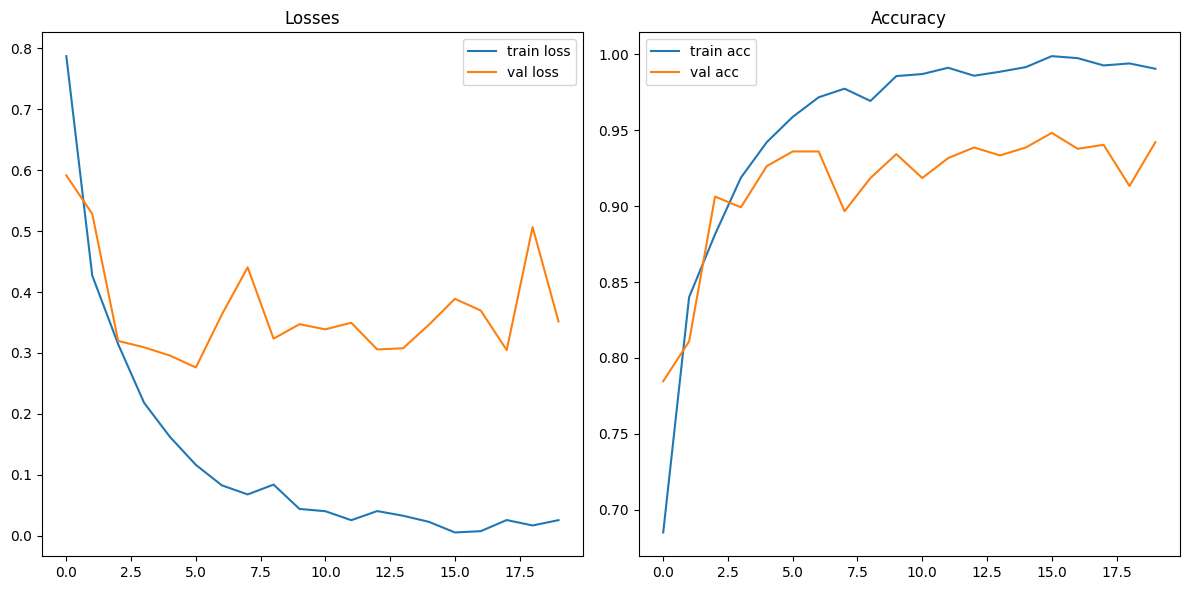

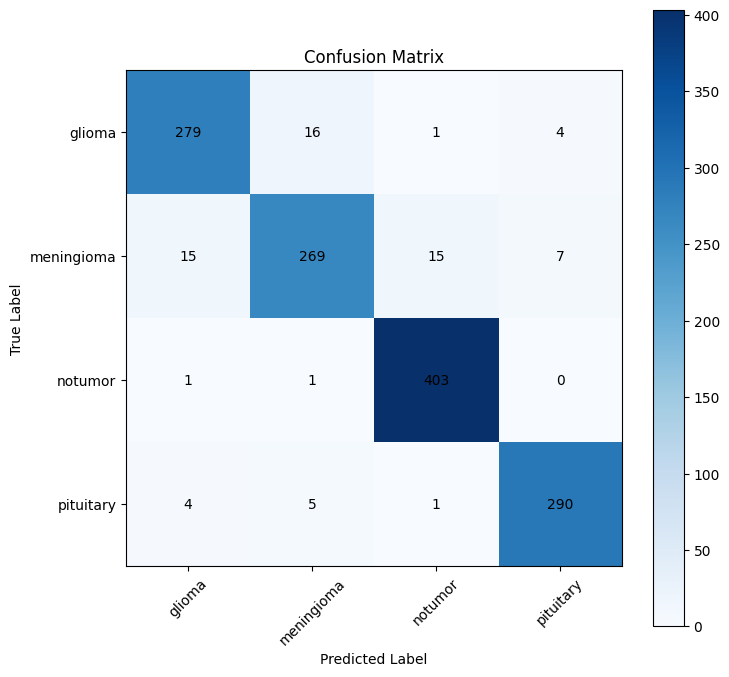

In [66]:
train_ds, val_ds = prepare_train_and_val_datasets()

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history5 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history5.history['loss'], label='train loss')
plt.plot(history5.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history5.history['accuracy'], label='train acc')
plt.plot(history5.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions5 = eval_model_on_test(model)

# get the predicted labels

predicted_labels5 = np.argmax(predictions5, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels5, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels5)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('models/brain_tumor_classifier_v5.keras')

In [67]:
report5 = classification_report(test_labels, predicted_labels5, target_names=classes, output_dict=True)

recall_dict['CNN_4LayerDeeper_Conv2D'] = report5['meningioma']['recall']
f1_weighted_dict['CNN_4LayerDeeper_Conv2D'] = report5['weighted avg']['f1-score']

In [70]:
recall_dict

{'CNN_1Layer_Conv2D': 0.8464052287581699,
 'CNN_2Layer_Conv2D': 0.8431372549019608,
 'CNN_3Layer_Conv2D': 0.8888888888888888,
 'CNN_4Layer_Conv2D': 0.9150326797385621,
 'CNN_3LayerDeeper_Conv2D': 0.9052287581699346,
 'CNN_4LayerDeeper_Conv2D': 0.8790849673202614}

In [71]:
f1_weighted_dict

{'CNN_1Layer_Conv2D': 0.929325406610462,
 'CNN_2Layer_Conv2D': 0.919806584690261,
 'CNN_3Layer_Conv2D': 0.9471006960550908,
 'CNN_4Layer_Conv2D': 0.9503438154669683,
 'CNN_3LayerDeeper_Conv2D': 0.9607958581643302,
 'CNN_4LayerDeeper_Conv2D': 0.946159243644747}

# **Data augmentation**

**Data augmentation by flipping left right**

In [72]:
# add augmentation directly to the training set like:
train_ds, val_ds = prepare_train_and_val_datasets()
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label))
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


Epoch 1/20
143/143 [==============================] - 9s 52ms/step - loss: 0.7627 - accuracy: 0.6829 - val_loss: 0.5368 - val_accuracy: 0.7644
Epoch 2/20
143/143 [==============================] - 7s 46ms/step - loss: 0.3992 - accuracy: 0.8460 - val_loss: 0.4100 - val_accuracy: 0.8608
Epoch 3/20
143/143 [==============================] - 8s 54ms/step - loss: 0.2976 - accuracy: 0.8891 - val_loss: 0.2700 - val_accuracy: 0.9116
Epoch 4/20
143/143 [==============================] - 8s 52ms/step - loss: 0.1952 - accuracy: 0.9267 - val_loss: 0.2531 - val_accuracy: 0.9133
Epoch 5/20
143/143 [==============================] - 7s 47ms/step - loss: 0.1273 - accuracy: 0.9543 - val_loss: 0.2284 - val_accuracy: 0.9308
Epoch 6/20
143/143 [==============================] - 8s 52ms/step - loss: 0.1040 - accuracy: 0.9632 - val_loss: 0.2058 - val_accuracy: 0.9352
Epoch 7/20
143/143 [==============================] - 7s 47ms/step - loss: 0.0657 - accuracy: 0.9775 - val_loss: 0.2117 - val_accuracy: 0.9457

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:10,  1.08s/it]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.93it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.95it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.87it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.54it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.11it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.56it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  5.93it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.21it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.42it/s]

1/1 [==============================] - 0s 76ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.42it/s]


              precision    recall  f1-score   support

      glioma       0.98      0.92      0.95       300
  meningioma       0.92      0.94      0.93       306
     notumor       0.98      0.99      0.99       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.97      0.96      0.96      1311



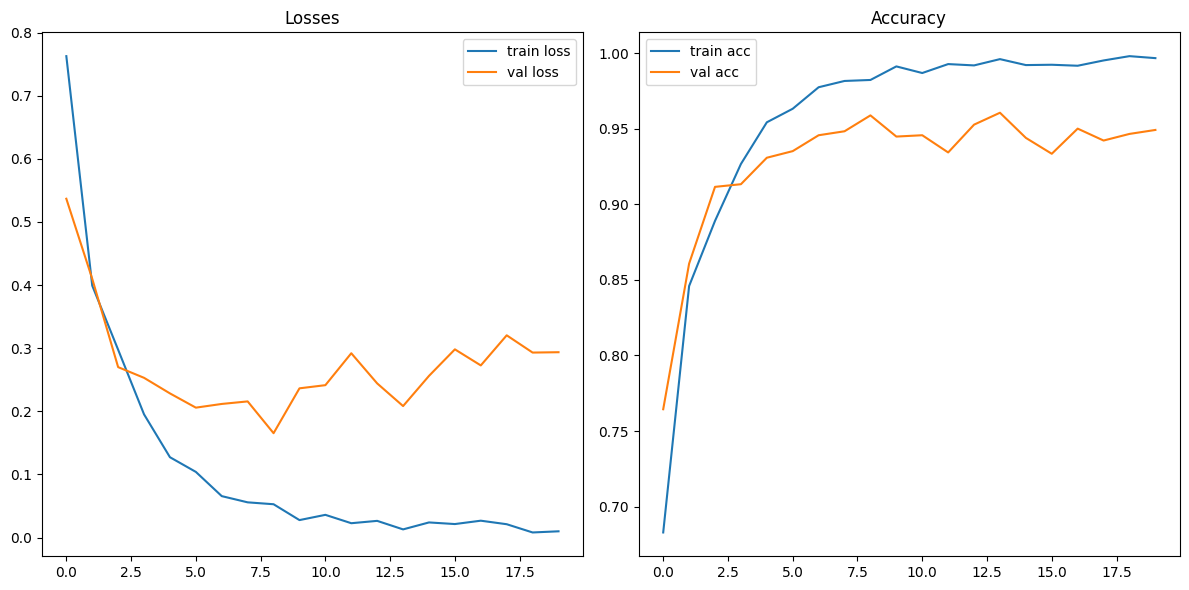

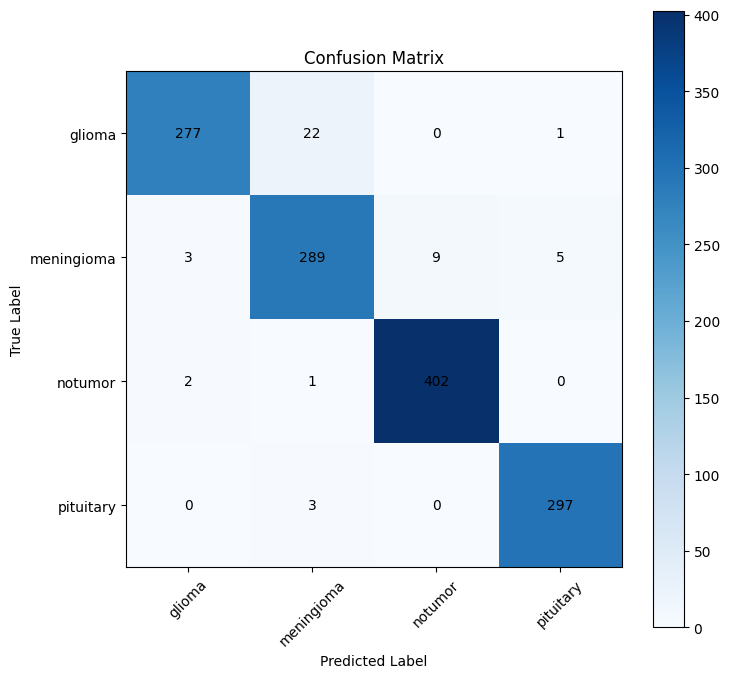

In [73]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# tarin the model

history6 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history6.history['loss'], label='train loss')
plt.plot(history6.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history6.history['accuracy'], label='train acc')
plt.plot(history6.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions6 = eval_model_on_test(model)

# get the predicted labels

predicted_labels6 = np.argmax(predictions6, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels6, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels6)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()

# save the model
model.save('models/brain_tumor_classifier_v6.keras')

In [74]:
report6 = classification_report(test_labels, predicted_labels6, target_names=classes, output_dict=True)

recall_dict['CNN_3LD_Flip_LeftRight'] = report6['meningioma']['recall']
f1_weighted_dict['CNN_3LD_Flip_LeftRight'] = report6['weighted avg']['f1-score']

In [75]:
recall_dict

{'CNN_1Layer_Conv2D': 0.8464052287581699,
 'CNN_2Layer_Conv2D': 0.8431372549019608,
 'CNN_3Layer_Conv2D': 0.8888888888888888,
 'CNN_4Layer_Conv2D': 0.9150326797385621,
 'CNN_3LayerDeeper_Conv2D': 0.9052287581699346,
 'CNN_4LayerDeeper_Conv2D': 0.8790849673202614,
 'CNN_3LD_Flip_LeftRight': 0.9444444444444444}

In [76]:
train_ds, val_ds = prepare_train_and_val_datasets()
train_ds = (train_ds.map(lambda image, label: (tf.image.random_flip_up_down(image), label))
                        .prefetch(buffer_size=tf.data.AUTOTUNE))

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


Epoch 1/20
143/143 [==============================] - 9s 45ms/step - loss: 0.8156 - accuracy: 0.6621 - val_loss: 0.5663 - val_accuracy: 0.7890
Epoch 2/20
143/143 [==============================] - 7s 49ms/step - loss: 0.4599 - accuracy: 0.8282 - val_loss: 0.5680 - val_accuracy: 0.7960
Epoch 3/20
143/143 [==============================] - 6s 43ms/step - loss: 0.3822 - accuracy: 0.8593 - val_loss: 0.3485 - val_accuracy: 0.8730
Epoch 4/20
143/143 [==============================] - 7s 49ms/step - loss: 0.2801 - accuracy: 0.8976 - val_loss: 0.3141 - val_accuracy: 0.8897
Epoch 5/20
143/143 [==============================] - 6s 42ms/step - loss: 0.2253 - accuracy: 0.9193 - val_loss: 0.4121 - val_accuracy: 0.8651
Epoch 6/20
143/143 [==============================] - 7s 50ms/step - loss: 0.1728 - accuracy: 0.9394 - val_loss: 0.3001 - val_accuracy: 0.8949
Epoch 7/20
143/143 [==============================] - 6s 44ms/step - loss: 0.1117 - accuracy: 0.9593 - val_loss: 0.2716 - val_accuracy: 0.9159

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 11ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:10,  1.08s/it]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.92it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.92it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.75it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.39it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:01,  4.94it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.60it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  6.23it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.42it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.94it/s]

1/1 [==============================] - 0s 78ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.44it/s]


              precision    recall  f1-score   support

      glioma       0.90      0.94      0.92       300
  meningioma       0.91      0.85      0.88       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.98      0.97      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



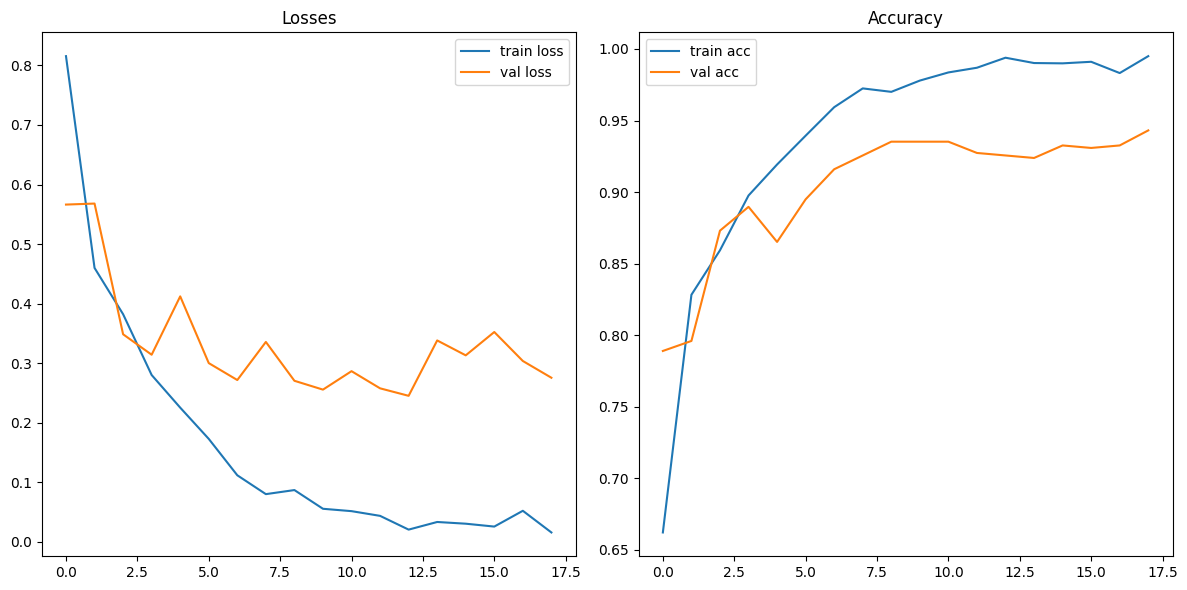

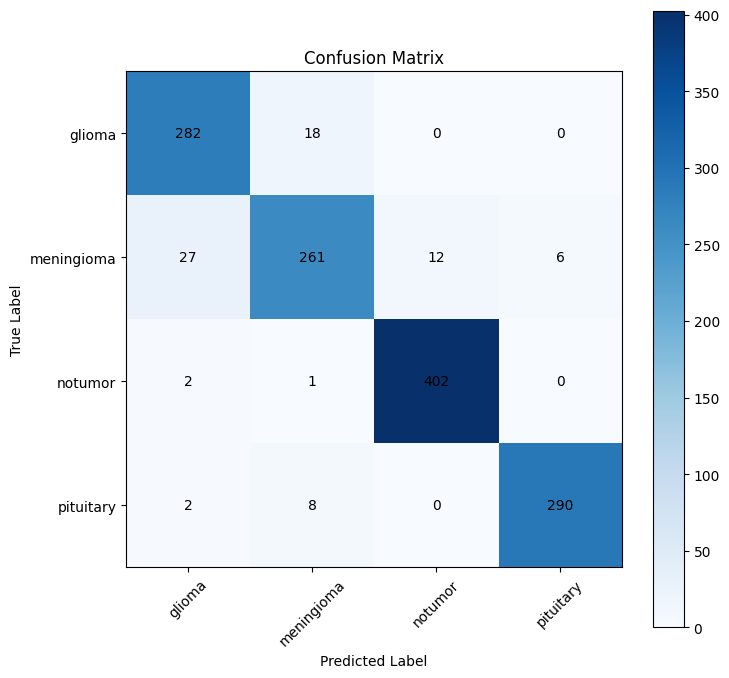

In [77]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# tarin the model

history7 = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history7.history['loss'], label='train loss')
plt.plot(history7.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history7.history['accuracy'], label='train acc')
plt.plot(history7.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions7 = eval_model_on_test(model)

# get the predicted labels

predicted_labels7 = np.argmax(predictions7, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels7, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels7)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()


In [78]:
report7 = classification_report(test_labels, predicted_labels7, target_names=classes, output_dict=True)

recall_dict['CNN_3LD_Flip_UPDOWN'] = report7['meningioma']['recall']
f1_weighted_dict['CNN_3LD_Flip_UPDOWN'] = report7['weighted avg']['f1-score']

In [80]:
f1_weighted_dict


{'CNN_1Layer_Conv2D': 0.929325406610462,
 'CNN_2Layer_Conv2D': 0.919806584690261,
 'CNN_3Layer_Conv2D': 0.9471006960550908,
 'CNN_4Layer_Conv2D': 0.9503438154669683,
 'CNN_3LayerDeeper_Conv2D': 0.9607958581643302,
 'CNN_4LayerDeeper_Conv2D': 0.946159243644747,
 'CNN_3LD_Flip_LeftRight': 0.9648704120663137,
 'CNN_3LD_Flip_UPDOWN': 0.9416150976909111}

In [92]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),  # Corrected from "left_right" to "horizontal"
  layers.RandomRotation(0.022),    # Assuming you want a rotation factor of approximately 0.041
])


In [93]:
train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


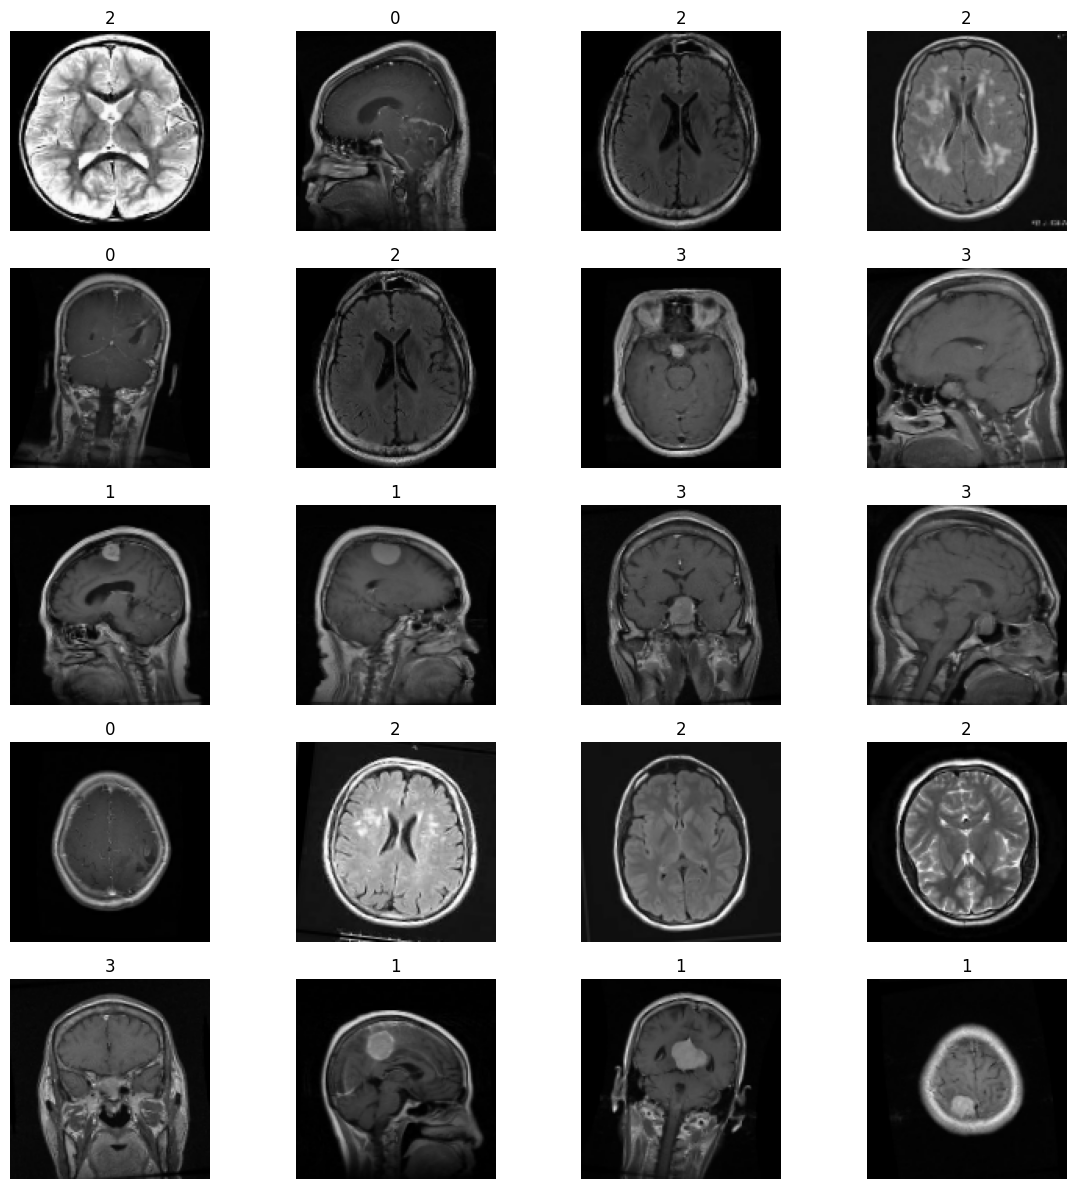

In [94]:
plt.figure(figsize=(12, 12))

for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.tight_layout()

Epoch 1/20
143/143 [==============================] - 24s 144ms/step - loss: 0.7279 - accuracy: 0.6996 - val_loss: 0.4499 - val_accuracy: 0.8266
Epoch 2/20
143/143 [==============================] - 16s 109ms/step - loss: 0.4163 - accuracy: 0.8435 - val_loss: 0.3611 - val_accuracy: 0.8800
Epoch 3/20
143/143 [==============================] - 13s 93ms/step - loss: 0.3269 - accuracy: 0.8786 - val_loss: 0.3100 - val_accuracy: 0.8940
Epoch 4/20
143/143 [==============================] - 13s 93ms/step - loss: 0.2513 - accuracy: 0.9077 - val_loss: 0.3303 - val_accuracy: 0.8897
Epoch 5/20
143/143 [==============================] - 13s 92ms/step - loss: 0.2082 - accuracy: 0.9239 - val_loss: 0.3075 - val_accuracy: 0.9098
Epoch 6/20
143/143 [==============================] - 13s 92ms/step - loss: 0.1840 - accuracy: 0.9298 - val_loss: 0.3153 - val_accuracy: 0.8967
Epoch 7/20
143/143 [==============================] - 13s 92ms/step - loss: 0.1360 - accuracy: 0.9499 - val_loss: 0.2911 - val_accurac

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 15ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:02<00:21,  2.11s/it]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:02<00:08,  1.02it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:02<00:04,  1.69it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:02<00:02,  2.39it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:02<00:01,  3.17it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:02<00:01,  3.95it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:02<00:00,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:03<00:00,  5.41it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:03<00:00,  5.78it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:03<00:00,  6.40it/s]

1/1 [==============================] - 0s 83ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:05<00:00,  2.15it/s]


              precision    recall  f1-score   support

      glioma       0.96      0.92      0.94       300
  meningioma       0.91      0.92      0.92       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.98      0.98      0.98       300

    accuracy                           0.95      1311
   macro avg       0.95      0.95      0.95      1311
weighted avg       0.96      0.95      0.95      1311



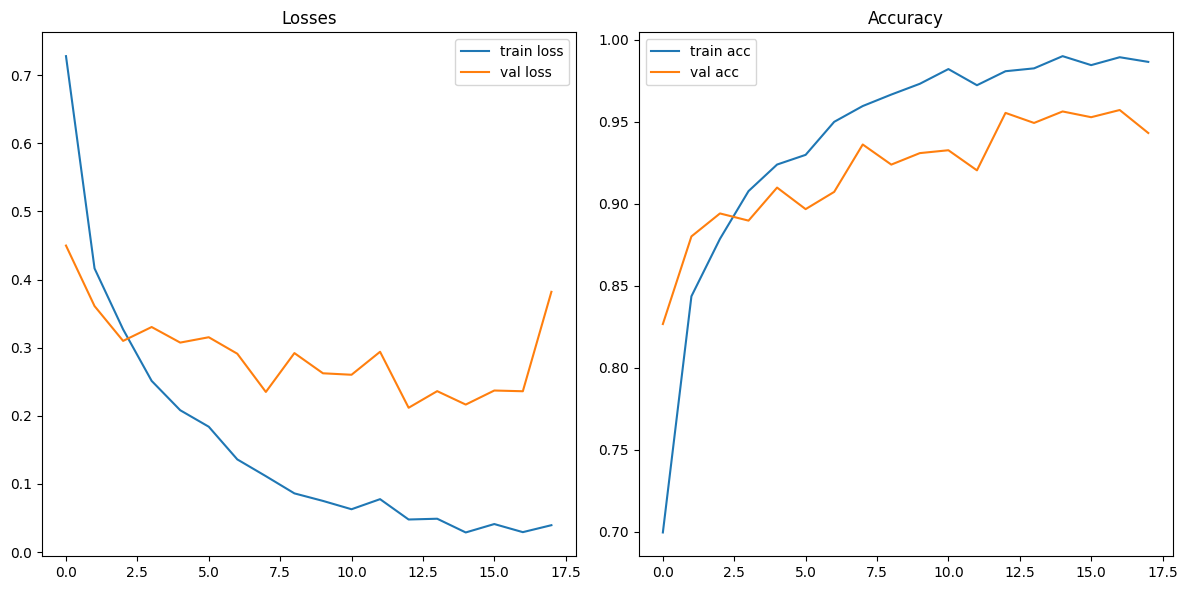

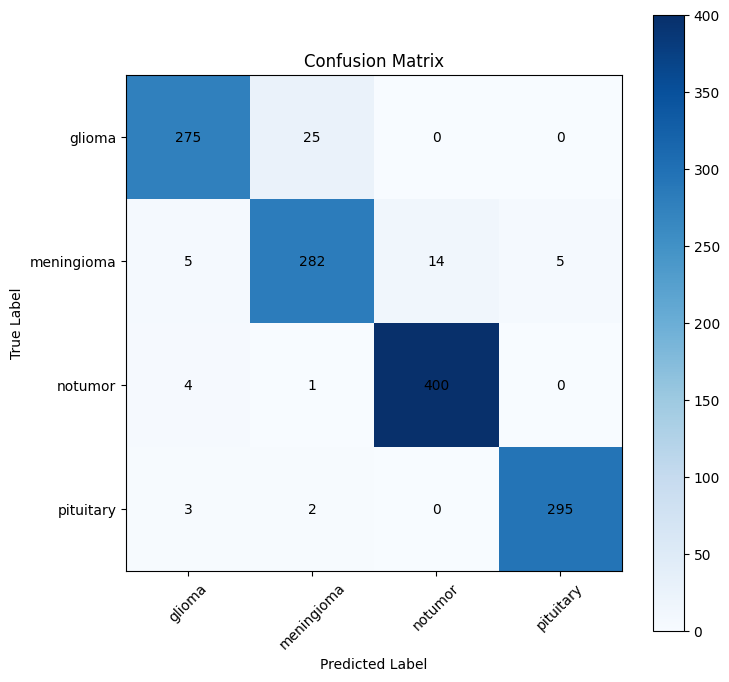

In [96]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# tarin the model

history8 = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history8.history['loss'], label='train loss')
plt.plot(history8.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history8.history['accuracy'], label='train acc')
plt.plot(history8.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions8 = eval_model_on_test(model)

# get the predicted labels

predicted_labels8 = np.argmax(predictions8, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels8, target_names=classes))

# get the confusion matrix

cm = confusion_matrix(test_labels, predicted_labels8)

plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()
plt.xticks(np.arange(4), classes, rotation=45)
plt.yticks(np.arange(4), classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.title('Confusion Matrix')
plt.show()


In [97]:
report9 = classification_report(test_labels, predicted_labels8, target_names=classes, output_dict=True)

recall_dict['CNN_3LD_Flip_LEFTRIGHT_ROT8'] = report9['meningioma']['recall']
f1_weighted_dict['CNN_3LD_Flip_LEFTRIGHT_ROT8'] = report9['weighted avg']['f1-score']

In [99]:
f1_weighted_dict

{'CNN_1Layer_Conv2D': 0.929325406610462,
 'CNN_2Layer_Conv2D': 0.919806584690261,
 'CNN_3Layer_Conv2D': 0.9471006960550908,
 'CNN_4Layer_Conv2D': 0.9503438154669683,
 'CNN_3LayerDeeper_Conv2D': 0.9607958581643302,
 'CNN_4LayerDeeper_Conv2D': 0.946159243644747,
 'CNN_3LD_Flip_LeftRight': 0.9648704120663137,
 'CNN_3LD_Flip_UPDOWN': 0.9416150976909111,
 'CNN_3LD_Flip_LEFTRIGHT_ROT15': 0.9446361178687417,
 'CNN_3LD_Flip_LEFTRIGHT_ROT8': 0.9548920796196827}

In [103]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),  # Corrected from "left_right" to "horizontal"
  layers.RandomContrast(factor=[0.1,0.9], seed=42)
])


In [104]:
train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.


Epoch 1/20
143/143 [==============================] - 10s 57ms/step - loss: 0.7580 - accuracy: 0.6864 - val_loss: 0.5800 - val_accuracy: 0.7802
Epoch 2/20
143/143 [==============================] - 7s 49ms/step - loss: 0.4444 - accuracy: 0.8245 - val_loss: 0.4336 - val_accuracy: 0.8468
Epoch 3/20
143/143 [==============================] - 7s 50ms/step - loss: 0.3428 - accuracy: 0.8700 - val_loss: 0.2900 - val_accuracy: 0.9089
Epoch 4/20
143/143 [==============================] - 8s 57ms/step - loss: 0.2371 - accuracy: 0.9114 - val_loss: 0.3114 - val_accuracy: 0.8949
Epoch 5/20
143/143 [==============================] - 9s 58ms/step - loss: 0.1752 - accuracy: 0.9361 - val_loss: 0.2608 - val_accuracy: 0.9081
Epoch 6/20
143/143 [==============================] - 7s 49ms/step - loss: 0.1426 - accuracy: 0.9460 - val_loss: 0.2958 - val_accuracy: 0.9081
Epoch 7/20
143/143 [==============================] - 8s 54ms/step - loss: 0.0855 - accuracy: 0.9709 - val_loss: 0.2350 - val_accuracy: 0.929

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 12ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:10,  1.07s/it]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.89it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.91it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.87it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.57it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.24it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.92it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  6.20it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.43it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.77it/s]

1/1 [==============================] - 0s 78ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.49it/s]


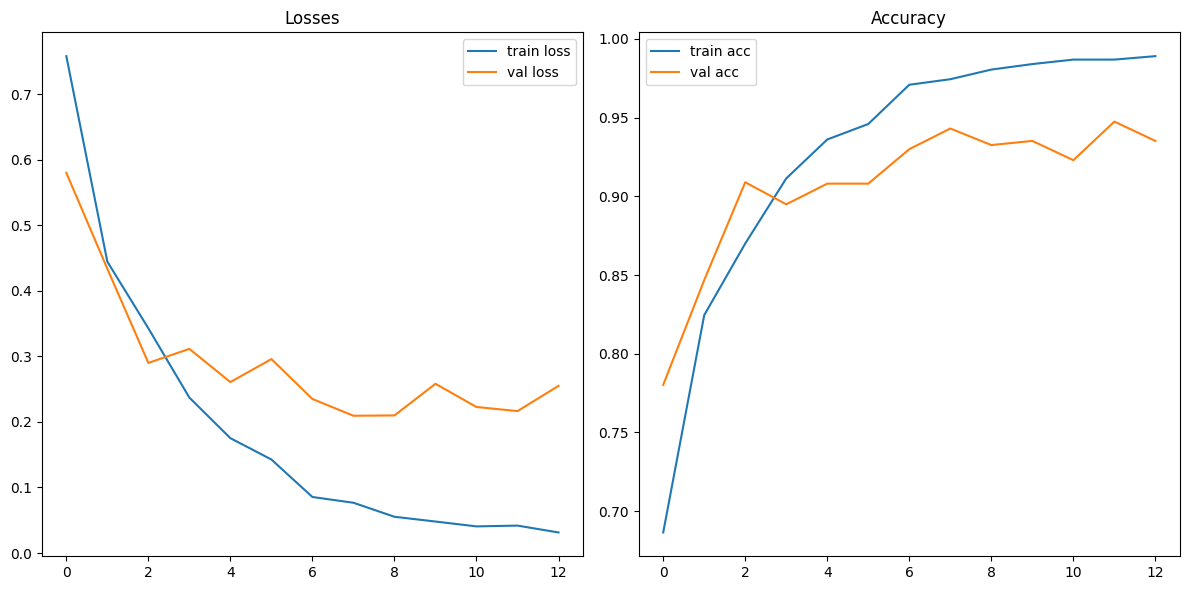

In [105]:
model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# tarin the model

history10 = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history10.history['loss'], label='train loss')
plt.plot(history10.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history10.history['accuracy'], label='train acc')
plt.plot(history10.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions10 = eval_model_on_test(model)

# get the predicted labels

predicted_labels10 = np.argmax(predictions10, axis=1)

report10 = classification_report(test_labels, predicted_labels10, target_names=classes, output_dict=True)

recall_dict['CNN_3LD_Flip_LEFTRIGHT_CONTRAST'] = report10['meningioma']['recall']
f1_weighted_dict['CNN_3LD_Flip_LEFTRIGHT_CONTRAST'] = report10['weighted avg']['f1-score']



In [108]:
f1_weighted_dict

{'CNN_1Layer_Conv2D': 0.929325406610462,
 'CNN_2Layer_Conv2D': 0.919806584690261,
 'CNN_3Layer_Conv2D': 0.9471006960550908,
 'CNN_4Layer_Conv2D': 0.9503438154669683,
 'CNN_3LayerDeeper_Conv2D': 0.9607958581643302,
 'CNN_4LayerDeeper_Conv2D': 0.946159243644747,
 'CNN_3LD_Flip_LeftRight': 0.9648704120663137,
 'CNN_3LD_Flip_UPDOWN': 0.9416150976909111,
 'CNN_3LD_Flip_LEFTRIGHT_ROT15': 0.9446361178687417,
 'CNN_3LD_Flip_LEFTRIGHT_ROT8': 0.9548920796196827,
 'CNN_3LD_Flip_LEFTRIGHT_CONTRAST': 0.9430831320175085}

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Epoch 1/20
143/143 [==============================] - 10s 50ms/step - loss: 0.8318 - accuracy: 0.6510 - val_loss: 0.7579 - val_accuracy: 0.6813
Epoch 2/20
143/143 [==============================] - 9s 58ms/step - loss: 0.4970 - accuracy: 0.8063 - val_loss: 0.5517 - val_accuracy: 0.8030
Epoch 3/20
143/143 [==============================] - 9s 59ms/step - loss: 0.3985 - accuracy: 0.8545 - val_loss: 0.3791 - val_accuracy: 0.8625
Epoch 4/20
143/143 [==============================] - 7s 48ms/step - loss: 0.3148 - accuracy: 0.8796 - val_loss: 0.3834 - val_accuracy: 0.8634
Epoch 5/20
143/143 [==============================] - 7s 49ms/step - loss: 0.2560 - accuracy: 0.9059 - val_loss: 0.3953 - val_accuracy: 0.8651
Epoch 6/20
143/143 [==============================] - 8s 53ms/step - loss: 0.2095 - accuracy: 0.9201 - val_loss: 0.3004 - val_accuracy: 0.

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 10ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:10,  1.09s/it]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.93it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.94it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.95it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.66it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.24it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.62it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  6.17it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.68it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  7.16it/s]

1/1 [==============================] - 0s 75ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.58it/s]


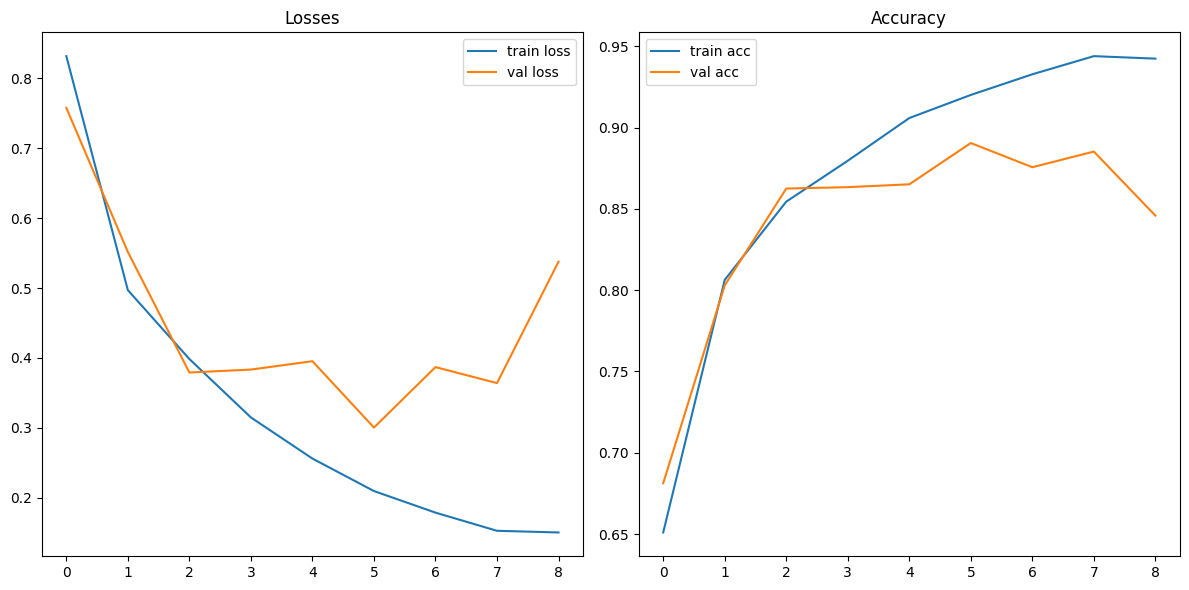

In [112]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),  # Corrected from "left_right" to "horizontal"
  layers.RandomCrop(height=int(0.95*128), width=int(0.95*128)),
  layers.Resizing(128, 128)
])

train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# tarin the model

history11 = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history11.history['loss'], label='train loss')
plt.plot(history11.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history11.history['accuracy'], label='train acc')
plt.plot(history11.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions11 = eval_model_on_test(model)

# get the predicted labels

predicted_labels11 = np.argmax(predictions11, axis=1)

report11 = classification_report(test_labels, predicted_labels11, target_names=classes, output_dict=True)

recall_dict['CNN_3LD_Flip_LEFTRIGHT_CROP5%'] = report11['meningioma']['recall']
f1_weighted_dict['CNN_3LD_Flip_LEFTRIGHT_CROP5%'] = report11['weighted avg']['f1-score']



In [114]:
f1_weighted_dict

{'CNN_1Layer_Conv2D': 0.929325406610462,
 'CNN_2Layer_Conv2D': 0.919806584690261,
 'CNN_3Layer_Conv2D': 0.9471006960550908,
 'CNN_4Layer_Conv2D': 0.9503438154669683,
 'CNN_3LayerDeeper_Conv2D': 0.9607958581643302,
 'CNN_4LayerDeeper_Conv2D': 0.946159243644747,
 'CNN_3LD_Flip_LeftRight': 0.9648704120663137,
 'CNN_3LD_Flip_UPDOWN': 0.9416150976909111,
 'CNN_3LD_Flip_LEFTRIGHT_ROT15': 0.9446361178687417,
 'CNN_3LD_Flip_LEFTRIGHT_ROT8': 0.9548920796196827,
 'CNN_3LD_Flip_LEFTRIGHT_CONTRAST': 0.9430831320175085,
 'CNN_3LD_Flip_LEFTRIGHT_CROP5%': 0.8833954660008049}

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Epoch 1/20
143/143 [==============================] - 15s 88ms/step - loss: 0.7807 - accuracy: 0.6834 - val_loss: 0.5416 - val_accuracy: 0.7977
Epoch 2/20
143/143 [==============================] - 14s 95ms/step - loss: 0.4252 - accuracy: 0.8418 - val_loss: 0.4870 - val_accuracy: 0.8380
Epoch 3/20
143/143 [==============================] - 14s 95ms/step - loss: 0.3309 - accuracy: 0.8755 - val_loss: 0.3344 - val_accuracy: 0.8923
Epoch 4/20
143/143 [==============================] - 13s 90ms/step - loss: 0.2411 - accuracy: 0.9085 - val_loss: 0.3429 - val_accuracy: 0.8967
Epoch 5/20
143/143 [==============================] - 13s 92ms/step - loss: 0.1732 - accuracy: 0.9392 - val_loss: 0.2740 - val_accuracy: 0.9203
Epoch 6/20
143/143 [==============================] - 13s 91ms/step - loss: 0.1604 - accuracy: 0.9457 - val_loss: 0.2174 - val_accurac

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:11,  1.16s/it]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.81it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.72it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.69it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.55it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.29it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.60it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  6.04it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.52it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  7.02it/s]

1/1 [==============================] - 0s 80ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]


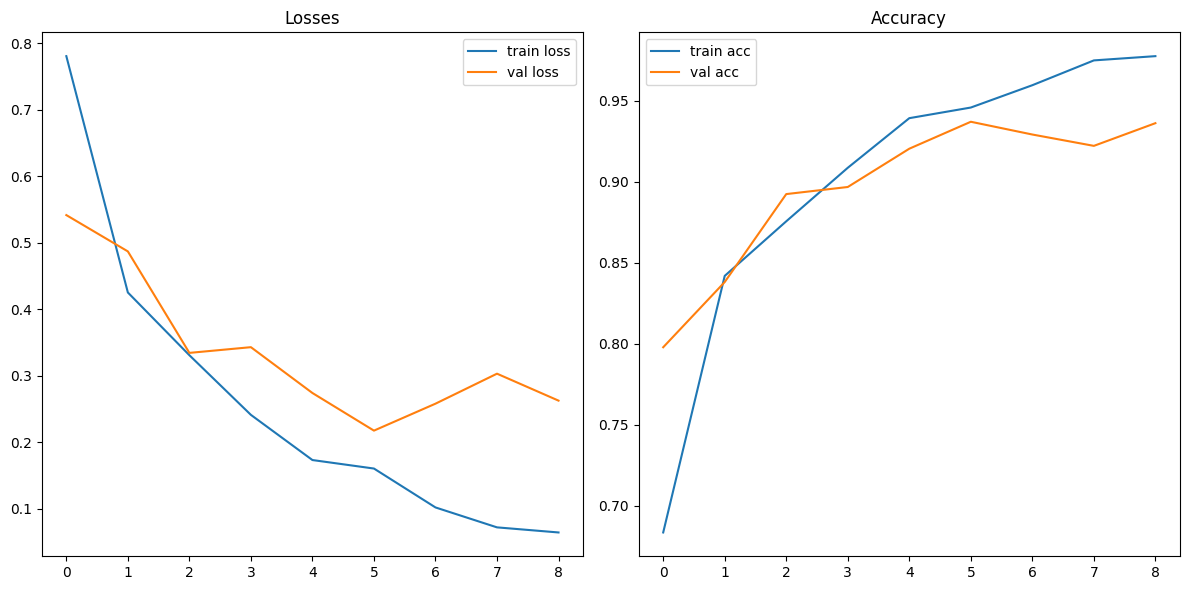

In [115]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),  # Corrected from "left_right" to "horizontal"
  layers.RandomTranslation(height_factor=0.002, width_factor=0.002)
])

train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# tarin the model

history12 = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history12.history['loss'], label='train loss')
plt.plot(history12.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history12.history['accuracy'], label='train acc')
plt.plot(history12.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions12 = eval_model_on_test(model)

# get the predicted labels

predicted_labels12 = np.argmax(predictions12, axis=1)

report12 = classification_report(test_labels, predicted_labels12, target_names=classes, output_dict=True)

recall_dict['CNN_3LD_Flip_LEFTRIGHT_TRANSLATE_002'] = report12['meningioma']['recall']
f1_weighted_dict['CNN_3LD_Flip_LEFTRIGHT_TRANSLATE_002'] = report12['weighted avg']['f1-score']



Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Epoch 1/20
143/143 [==============================] - 10s 51ms/step - loss: 0.7543 - accuracy: 0.6871 - val_loss: 0.5167 - val_accuracy: 0.7925
Epoch 2/20
143/143 [==============================] - 7s 47ms/step - loss: 0.4349 - accuracy: 0.8304 - val_loss: 0.4853 - val_accuracy: 0.8240
Epoch 3/20
143/143 [==============================] - 8s 54ms/step - loss: 0.3476 - accuracy: 0.8672 - val_loss: 0.3630 - val_accuracy: 0.8809
Epoch 4/20
143/143 [==============================] - 8s 54ms/step - loss: 0.2554 - accuracy: 0.9013 - val_loss: 0.2857 - val_accuracy: 0.9011
Epoch 5/20
143/143 [==============================] - 7s 48ms/step - loss: 0.1690 - accuracy: 0.9427 - val_loss: 0.2948 - val_accuracy: 0.9072
Epoch 6/20
143/143 [==============================] - 8s 53ms/step - loss: 0.1449 - accuracy: 0.9481 - val_loss: 0.2112 - val_accuracy: 0.

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:01<00:10,  1.08s/it]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:01<00:04,  1.93it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:01<00:02,  2.93it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:01<00:01,  3.87it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:01<00:01,  4.69it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:01<00:00,  5.10it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:01<00:00,  5.49it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:02<00:00,  5.81it/s]

4/4 [==============================] - 0s 8ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:02<00:00,  6.35it/s]

4/4 [==============================] - 0s 9ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:02<00:00,  6.54it/s]

1/1 [==============================] - 0s 75ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:02<00:00,  4.31it/s]


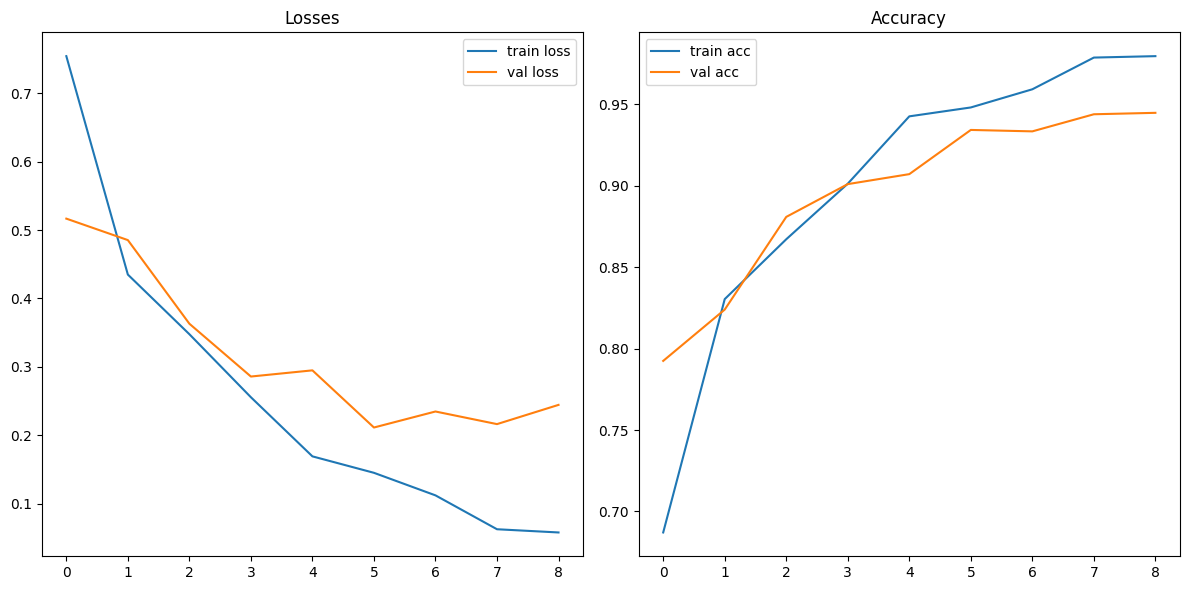

In [131]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),  # Corrected from "left_right" to "horizontal"
  layers.RandomBrightness(factor=0.01)
])

train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))


model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(4)
])

model.build(input_shape=(None, 128, 128, 3))  # Build the model


model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
# tarin the model

history13 = model.fit(
    train_ds,
    validation_data=val_ds,callbacks= early_stopping_cb,
    epochs=20
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history13.history['loss'], label='train loss')
plt.plot(history13.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history13.history['accuracy'], label='train acc')
plt.plot(history13.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions13 = eval_model_on_test(model)

# get the predicted labels

predicted_labels13 = np.argmax(predictions13, axis=1)

report13 = classification_report(test_labels, predicted_labels13, target_names=classes, output_dict=True)

recall_dict['CNN_3LD_Flip_LEFTRIGHT_BRIGHTNESS_0.01'] = report13['meningioma']['recall']
f1_weighted_dict['CNN_3LD_Flip_LEFTRIGHT_BRIGHTNESS_0.01'] = report13['weighted avg']['f1-score']



In [132]:
{k: round(v, 4) for k, v in sorted(f1_weighted_dict.items(), key=lambda item: item[1], reverse=True)}

{'CNN_3LD_Flip_LeftRight': 0.9649,
 'CNN_3LD_Flip_LEFTRIGHT_BRIGHTNESS_0.05': 0.9639,
 'CNN_3LayerDeeper_Conv2D': 0.9608,
 'CNN_3LD_Flip_LEFTRIGHT_ROT8': 0.9549,
 'CNN_4Layer_Conv2D': 0.9503,
 'CNN_3Layer_Conv2D': 0.9471,
 'CNN_4LayerDeeper_Conv2D': 0.9462,
 'CNN_3LD_Flip_LEFTRIGHT_ROT15': 0.9446,
 'CNN_3LD_Flip_LEFTRIGHT_CONTRAST': 0.9431,
 'CNN_3LD_Flip_LEFTRIGHT_BRIGHTNESS_0.1': 0.9424,
 'CNN_3LD_Flip_UPDOWN': 0.9416,
 'CNN_3LD_Flip_LEFTRIGHT_TRANSLATE_002': 0.9334,
 'CNN_3LD_Flip_LEFTRIGHT_BRIGHTNESS_0.01': 0.9327,
 'CNN_1Layer_Conv2D': 0.9293,
 'CNN_2Layer_Conv2D': 0.9198,
 'CNN_3LD_Flip_LEFTRIGHT_CROP5%': 0.8834}

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
83683744/83683744 [==============================] - 2s 0us/step
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


143/143 [==============================] - 19s 88ms/step - loss: 3.5914 - accuracy: 0.4037 - val_loss: 1.2169 - val_accuracy: 0.4702
Epoch 2/20
143/143 [==============================] - 9s 64ms/step - loss: 1.2909 - accuracy: 0.4737 - val_loss: 1.0682 - val_accuracy: 0.5464
Epoch 3/20
143/143 [==============================] - 9s 63ms/step - loss: 1.1618 - accuracy: 0.5158 - val_loss: 0.9976 - val_accuracy: 0.6121
Epoch 4/20
143/143 [==============================] - 10s 65ms/step - loss: 1.0583 - accuracy: 0.5501 - val_loss: 0.8878 - val_accuracy: 0.6559
Epoch 5/20
143/143 [==============================] - 9s 59ms/step - loss: 1.0011 - accuracy: 0.5707 - val_loss: 0.8411 - val_accuracy: 0.6839
Epoch 6/20
143/143 [==============================] - 10s 68ms/step - loss: 0.9514 - accuracy: 0.5875 - val_loss: 0.8036 - val_accuracy: 0.6970
Epoch 7/20
143/143 [==============================] - 9s 61ms/step - loss: 0.9188 - accuracy: 0.6063 - val_loss: 0.7674 - val_accuracy: 0.7242
Epoch 8

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 1s 56ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:02<00:28,  2.83s/it]

4/4 [==============================] - 0s 42ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:03<00:11,  1.33s/it]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:03<00:07,  1.11it/s]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:03<00:04,  1.54it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:04<00:03,  1.78it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:04<00:02,  1.96it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:04<00:01,  2.11it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:05<00:01,  2.24it/s]

4/4 [==============================] - 0s 37ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:05<00:00,  2.62it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:05<00:00,  2.61it/s]

1/1 [==============================] - 2s 2s/step


Predicting on Test Data: 100%|██████████| 11/11 [00:08<00:00,  1.32it/s]

              precision    recall  f1-score   support

      glioma       0.67      0.61      0.64       300
  meningioma       0.60      0.52      0.56       306
     notumor       0.87      0.87      0.87       405
   pituitary       0.76      0.93      0.83       300

    accuracy                           0.74      1311
   macro avg       0.72      0.73      0.72      1311
weighted avg       0.73      0.74      0.74      1311



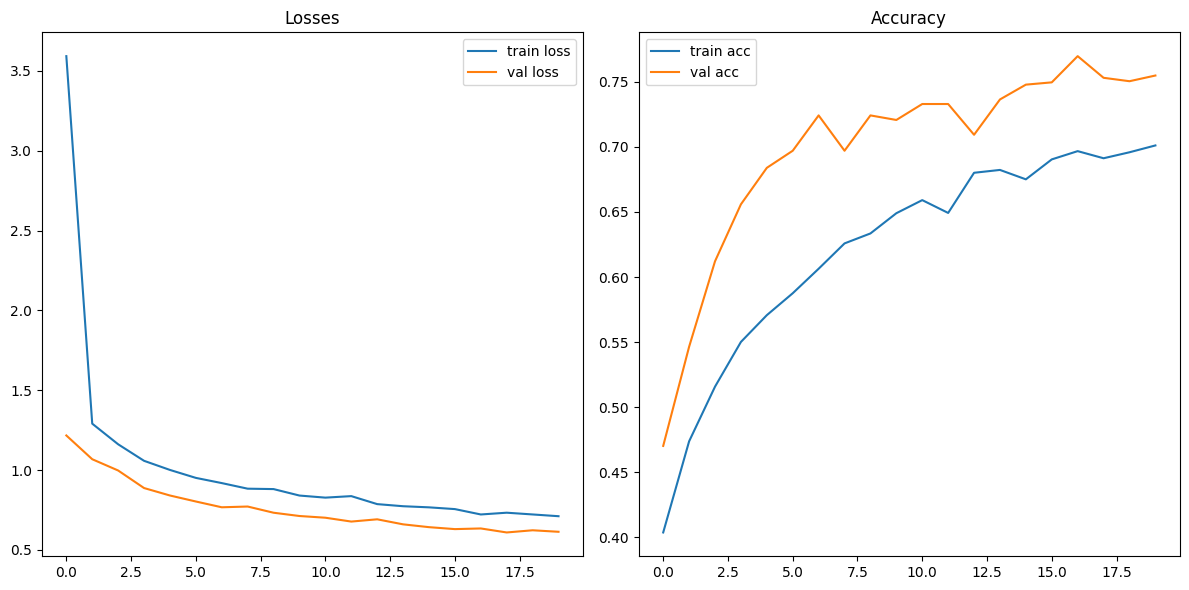

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adamax

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),  # Corrected from "left_right" to "horizontal"
])

train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
# Load the EfficientNetB0 model pre-trained on ImageNet
#base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=(128, 128, 3), pooling='max')

# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)


history14 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,callbacks= early_stopping_cb
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history14.history['loss'], label='train loss')
plt.plot(history14.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history14.history['accuracy'], label='train acc')
plt.plot(history14.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions14 = eval_model_on_test(model)

# get the predicted labels

predicted_labels14 = np.argmax(predictions14, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels14, target_names=classes))

# save the model
model.save('models/brain_tumor_classifier_v14.keras')

In [140]:
report14 = classification_report(test_labels, predicted_labels14, target_names=classes, output_dict=True)

recall_dict['XCEPTION_FROZEN'] = report14['meningioma']['recall']
f1_weighted_dict['XCEPTION_FROZEN'] = report14['weighted avg']['f1-score']

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Epoch 1/40
143/143 [==============================] - 54s 205ms/step - loss: 0.4811 - accuracy: 0.8344 - val_loss: 0.3429 - val_accuracy: 0.8967
Epoch 2/40
143/143 [==============================] - 26s 179ms/step - loss: 0.1281 - accuracy: 0.9578 - val_loss: 0.1590 - val_accuracy: 0.9492
Epoch 3/40
143/143 [==============================] - 26s 179ms/step - loss: 0.0818 - accuracy: 0.9783 - val_loss: 0.0695 - val_accuracy: 0.9799
Epoch 4/40
143/143 [==============================] - 26s 180ms/step - loss: 0.0378 - accuracy: 0.9877 - val_loss: 0.1153 - val_accuracy: 0.9729
Epoch 5/40
143/143 [==============================] - 26s 179ms/step - loss: 0.0410 - accuracy: 0.9888 - val_loss: 0.0833 - val_accuracy: 0.9799
Epoch 6/40
143/143 [==============================] - 27s 187ms/step - loss: 0.0362 - accuracy: 0.9884 - val_loss: 0.0454 - val_a

Predicting on Test Data:   0%|          | 0/11 [00:00<?, ?it/s]

4/4 [==============================] - 1s 61ms/step


Predicting on Test Data:   9%|▉         | 1/11 [00:02<00:20,  2.01s/it]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  18%|█▊        | 2/11 [00:02<00:09,  1.06s/it]

4/4 [==============================] - 0s 41ms/step


Predicting on Test Data:  27%|██▋       | 3/11 [00:02<00:06,  1.30it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  36%|███▋      | 4/11 [00:03<00:04,  1.56it/s]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  45%|████▌     | 5/11 [00:03<00:03,  1.93it/s]

4/4 [==============================] - 0s 40ms/step


Predicting on Test Data:  55%|█████▍    | 6/11 [00:04<00:02,  2.00it/s]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  64%|██████▎   | 7/11 [00:04<00:01,  2.06it/s]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  73%|███████▎  | 8/11 [00:04<00:01,  2.20it/s]

4/4 [==============================] - 0s 38ms/step


Predicting on Test Data:  82%|████████▏ | 9/11 [00:05<00:00,  2.30it/s]

4/4 [==============================] - 0s 39ms/step


Predicting on Test Data:  91%|█████████ | 10/11 [00:05<00:00,  2.38it/s]

1/1 [==============================] - 1s 747ms/step


Predicting on Test Data: 100%|██████████| 11/11 [00:10<00:00,  1.08it/s]


              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.97      0.99      0.98       306
     notumor       0.99      1.00      0.99       405
   pituitary       1.00      0.99      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



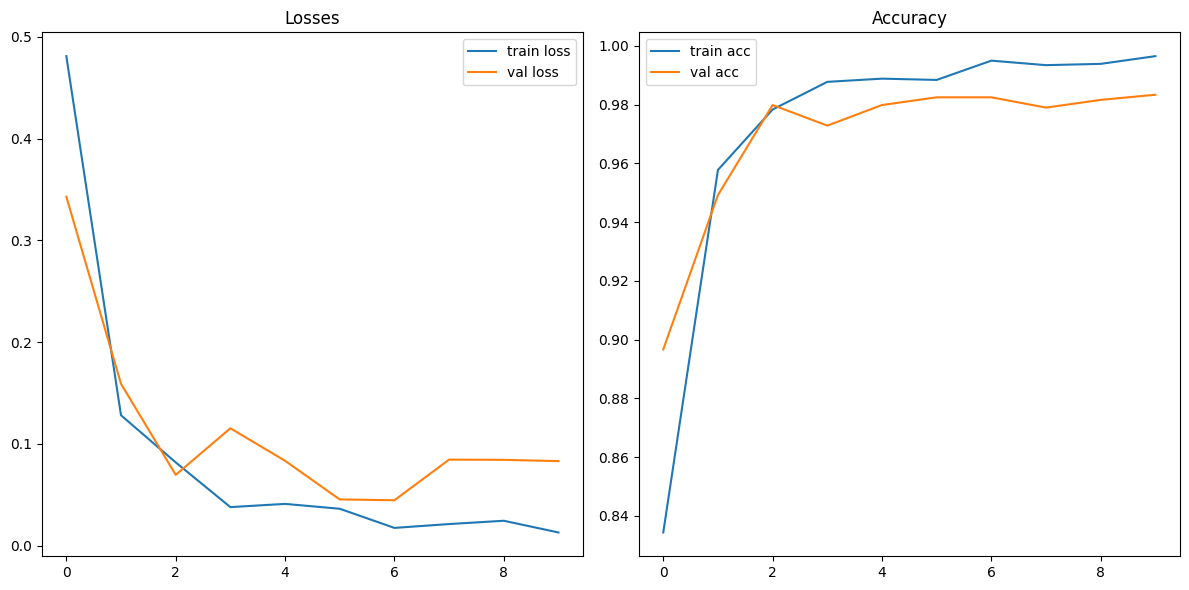

In [143]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
])

train_ds, val_ds = prepare_train_and_val_datasets()

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

base_model = tf.keras.applications.Xception(include_top=False, weights="imagenet", input_shape=(128, 128, 3), pooling='max')

# Unfreeze all layers in the base model
base_model.trainable = True

# Compile the model after unfreezing the base model
model = Sequential([
    base_model,
    Flatten(),
    Dropout(rate=0.3),
    Dense(128, activation='relu'),
    Dropout(rate=0.25),
    Dense(4)
])

# Compile the model
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

history14 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=early_stopping_cb
)

# plot the training history

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history14.history['loss'], label='train loss')
plt.plot(history14.history['val_loss'], label='val loss')
plt.legend()
plt.title('Losses')

plt.subplot(1, 2, 2)
plt.plot(history14.history['accuracy'], label='train acc')
plt.plot(history14.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()

# evaluate the model on the test data

test_labels, predictions14 = eval_model_on_test(model)

# get the predicted labels

predicted_labels14 = np.argmax(predictions14, axis=1)

# get the classification report

print(classification_report(test_labels, predicted_labels14, target_names=classes))

# save the model
model.save('models/brain_tumor_classifier_v14.keras')


In [144]:
report14 = classification_report(test_labels, predicted_labels14, target_names=classes, output_dict=True)

recall_dict['XCEPTION_UNFROZEN_ALL'] = report14['meningioma']['recall']
f1_weighted_dict['XCEPTION_UNFROZEN_ALl'] = report14['weighted avg']['f1-score']

In [146]:
{k: round(v, 4) for k, v in sorted(recall_dict.items(), key=lambda item: item[1], reverse=True)}

{'XCEPTION_UNFROZEN_ALL': 0.9935,
 'CNN_3LD_Flip_LeftRight': 0.9444,
 'CNN_3LD_Flip_LEFTRIGHT_BRIGHTNESS_0.05': 0.9248,
 'CNN_3LD_Flip_LEFTRIGHT_ROT8': 0.9216,
 'CNN_4Layer_Conv2D': 0.915,
 'CNN_3LayerDeeper_Conv2D': 0.9052,
 'CNN_3LD_Flip_LEFTRIGHT_CONTRAST': 0.8954,
 'CNN_3LD_Flip_LEFTRIGHT_BRIGHTNESS_0.1': 0.8954,
 'CNN_3Layer_Conv2D': 0.8889,
 'CNN_3LD_Flip_LEFTRIGHT_BRIGHTNESS_0.01': 0.8856,
 'CNN_4LayerDeeper_Conv2D': 0.8791,
 'CNN_3LD_Flip_LEFTRIGHT_ROT15': 0.866,
 'CNN_3LD_Flip_UPDOWN': 0.8529,
 'CNN_1Layer_Conv2D': 0.8464,
 'CNN_2Layer_Conv2D': 0.8431,
 'CNN_3LD_Flip_LEFTRIGHT_TRANSLATE_002': 0.8366,
 'CNN_3LD_Flip_LEFTRIGHT_CROP5%': 0.768,
 'XCEPTION_FROZEN': 0.5196}